Epoch 1 done ✅
Epoch 2 done ✅
Epoch 3 done ✅
Epoch 4 done ✅
Epoch 5 done ✅
Epoch 6 done ✅
Epoch 7 done ✅
Epoch 8 done ✅
Epoch 9 done ✅
Epoch 10 done ✅


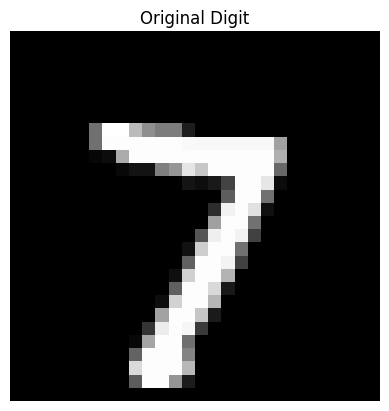

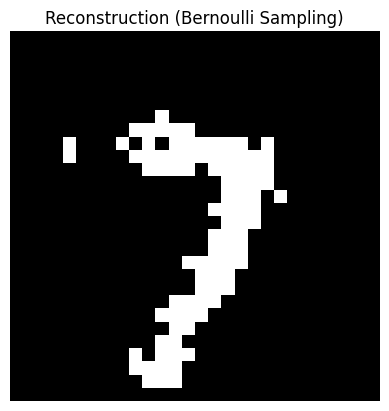

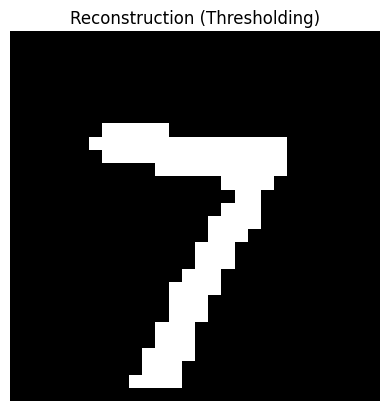

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
n_visible = 784   
n_hidden = 500
lr = 0.01
epochs = 10
batch_size = 64
 
transform = transforms.Compose([transforms.ToTensor()])
mnist_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)
 
W = torch.randn(n_hidden, n_visible) * 0.1
h_bias = torch.zeros(n_hidden)
v_bias = torch.zeros(n_visible)
 
def v_to_h(v):
    h_probs = torch.sigmoid(torch.matmul(v, W.T) + h_bias)
    h_sample = torch.bernoulli(h_probs)
    h_thresh = (h_probs > 0.5).float() # Thresholding since bernoulli uses randomness
    return h_probs, h_sample, h_thresh

def h_to_v(h):
    v_probs = torch.sigmoid(torch.matmul(h, W) + v_bias)
    v_sample = torch.bernoulli(v_probs)
    v_thresh = (v_probs > 0.5).float() # Thresholding since bernoulli uses randomness
    return v_probs, v_sample, v_thresh
 
def contrastive_divergence(v):
    h_probs, h_sample, _ = v_to_h(v)
    v_probs, v_sample, _ = h_to_v(h_sample)
    h_probs_neg, _, _ = v_to_h(v_probs)

    global W, h_bias, v_bias
    W += lr * (torch.matmul(h_probs.T, v) - torch.matmul(h_probs_neg.T, v_probs)) / v.size(0)
    v_bias += lr * torch.mean(v - v_probs, dim=0)
    h_bias += lr * torch.mean(h_probs - h_probs_neg, dim=0)
 
for epoch in range(epochs):
    total_loss = 0
    for batch, _ in mnist_loader:
        v = batch.view(-1, 784)
        contrastive_divergence(v)
    print(f"Epoch {epoch+1} done ✅")

test_img, _ = next(iter(mnist_loader))
test_v = test_img[0].view(-1)

_, h_b_sample, h_thresh = v_to_h(test_v)
_, recon_b, _ = h_to_v(h_b_sample)
_, _, recon_thresh = h_to_v(h_thresh)

def show_img(flat, title):
    plt.imshow(flat.view(28, 28).detach(), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

show_img(test_v, "Original Digit")
show_img(recon_b, "Reconstruction (Bernoulli Sampling)")
show_img(recon_thresh, "Reconstruction (Thresholding)")


# Oh!😅 We can't use threshold, since those randomness are responsible for new generation

In [ ]:
class RBM(nn.Module):
    def __init__(self, visible, hidden):  # Order should be visible, hidden to match your usage
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(hidden, visible) * 0.1)
        self.h_bias = nn.Parameter(torch.zeros(hidden))  # Changed from h to h_bias
        self.v_bias = nn.Parameter(torch.zeros(visible))  # Changed from v to v_bias
        
    def sample_h(self, v):
        h_prob = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return h_prob, torch.bernoulli(h_prob)
        
    def sample_v(self, h):
        v_prob = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return v_prob, torch.bernoulli(v_prob)
   
    def contrastive_derivative(self, v, lr=0.1):
        h_prob, h_sample = self.sample_h(v)
        v_prob, _ = self.sample_v(h_sample)  # Fixed asterisk
        h_prob_neg, _ = self.sample_h(v_prob)  # Fixed asterisk
 
        self.W.data += lr * (torch.matmul(h_prob.t(), v) - torch.matmul(h_prob_neg.t(), v_prob)) / v.size(0)
        self.v_bias.data += lr * torch.sum(v - v_prob, dim=0) / v.size(0)
        self.h_bias.data += lr * torch.sum(h_prob - h_prob_neg, dim=0) / v.size(0)
        return torch.mean((v - v_prob) ** 2)

class DBN(nn.Module):
    def __init__(self, layers):
        super(DBN, self).__init__()
        self.layers = layers
        self.rbm = nn.ModuleList([RBM(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.classifier = nn.Sequential(
            nn.Linear(layers[-1], 10),
        )
        
    def pre_train(self, data):
        images = data.tensors[0]  # Fixed tensors (plural)
        for i, rbm in enumerate(self.rbm):
            for epochs in range(10):
                for batch in DataLoader(images, batch_size=100, shuffle=True):
                    batch = batch.view(batch.size(0), -1)
                    rbm.contrastive_derivative(batch)
           
            h_prob, _ = rbm.sample_h(images)  # Fixed asterisk
            images = h_prob  # Store result for next RBM
            
    def forward(self, x):
        for rbm in self.rbm:
            h_prob, _ = rbm.sample_h(x)  # Fixed asterisk
            x = h_prob
        x = self.classifier(x)
        return x
   
    def finetune(self, data):  
        optimizer = torch.optim.SGD(self.parameters(), lr=0.1)
        criterion = nn.CrossEntropyLoss()  
        for epochs in range(10):
            for image, target in DataLoader(data, batch_size=64):
                image = image.view(image.size(0), -1)  # Added assignment
                optimizer.zero_grad()
                output = self.forward(image)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
            print(f"Epoch {epochs}, Loss: {loss.item()}")

